# Notebook to train and test standard ML models on the data

### Begin by setting up the data and defining the models

In [46]:
# Imports general
import pdb
import importlib
import pandas as pd
import numpy as np
from getpass import getuser
import matplotlib.pyplot as plt
%matplotlib inline
import make_aucs

# Imports scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import tree
from sklearn import svm
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [47]:
# Load UMD data
umd_file = '/Users/' + getuser() + '/Documents/Rhodes/RAIL/apnea_dev/data/umd_data_standard.csv'
data_umd = pd.read_csv(umd_file)

# Load chat data
chat_file = '/Users/' + getuser() + '/Documents/Rhodes/RAIL/apnea_dev/data/chat_data_standard.csv'
data_chat = pd.read_csv(chat_file)

# Define variables
admission_variables = ['gender_Male', 'ethnicity_Hispanic','ethnicity_Black', 'ethnicity_White', 'ethnicity_Asian', \
                       'term', 'bmi', 'age', 'allergies_Yes', 'asthma_Yes', 'gerd_Yes', 'tonsilsize_3-4', 'zscore']
laboratory_variables = ['nrem', 'rem', 'sleepefficiency', 'arousali', 'tst50co2', 'oahi', 'cai', \
                        'oai', 'ohi', 'lowsao2', 'peakc02', 'tb90']
test_variable = ['ahi']
continuous_variables = ["bmi", "age", 'zscore']
reference_variables = ['reference: osa18', 'reference: psq', 'reference: ess']

# Set AHI threshold
ahi_thresh = 5

# Set reference thresholds
ref_thresh = {'reference: osa18': 60, 'reference: psq': 0.33, 'reference: ess': 8.01}

# Set up train and test sets
xtrain = data_umd[admission_variables]
xtest = data_chat[admission_variables]
ytrain = pd.Series(data_umd['ahi']>ahi_thresh, index=data_umd.index)
ytest = pd.Series(data_chat['ahi']>ahi_thresh, index=data_chat.index)
yref = data_chat[reference_variables].copy()

In [77]:
# Initialise models
models = {\
'Logistic Regression l2 reg':LogisticRegression(penalty = 'l2'), \
'Logistic Regression l1 reg':LogisticRegression(penalty = 'l1'), \
'Logistic Regression': LogisticRegression(), \
'Decision Trees': tree.DecisionTreeClassifier(criterion='gini'), \
'SVM': svm.SVC(probability=True), \
'Random Forest': RandomForestClassifier(), \
'SVM linear': svm.SVC(probability=True, kernel='linear'), \
'SVM reg': svm.SVC(probability=True), \
'SVM linear reg': svm.SVC(probability=True, kernel='linear')}

In [99]:
# Useful functions...
def sens_and_spec(y_true, y_pred):
    
    """ Calculate sensitivity and specificity comparing predictions with reference results"""
    
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    
    return sensitivity, specificity

def match_sens(fpr, tpr, ref_sens):
    
    """ Calculate specificity for the sensitivity value that best matches a reference sensitivity"""
    
    # Find idx of closest tpr value greater than the reference sensitivity
    idx_greater = tpr >= ref_sens
    fpr = fpr[idx_greater]
    tpr = tpr[idx_greater]
    idx_closest = np.argmin(tpr - ref_sens)
    sensitivity = tpr[idx_closest]
    specificity = 1 - fpr[idx_closest]
    
    return sensitivity, specificity
    
    
def match_spec(fpr, tpr, ref_spec):
    
    """ Calculate sensitivity for the specificity value that best matches a reference specificity"""
    
    # Find idx of closest tpr value greater than the reference sensitivity
    spec = 1 - fpr
    idx_greater = spec >= ref_spec
    spec = spec[idx_greater]
    tpr = tpr[idx_greater]
    idx_closest = np.argmin(spec - ref_spec)
    sensitivity = tpr[idx_closest]
    specificity = spec[idx_closest]
    
    return sensitivity, specificity

### First try models without feature engineering

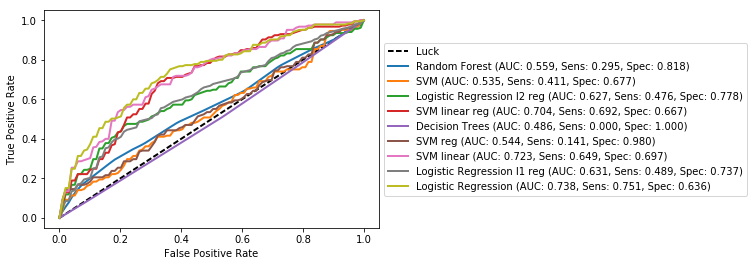

In [4]:
make_aucs.main(data = [xtrain, ytrain], models=models, kfolds=5)

### Try normalise the data

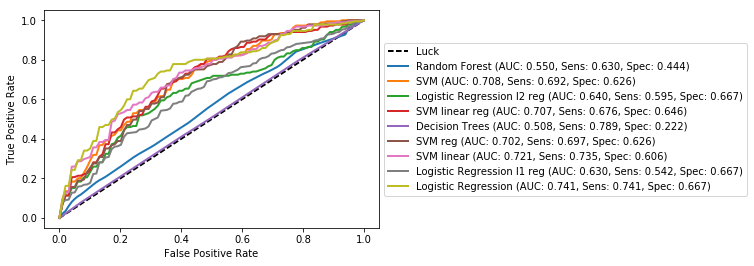

In [5]:
# Normalise continuous data
normalise_vars = list(set(continuous_variables) - set('zscore'))
xtrain_norm = xtrain.copy()
scaler = preprocessing.StandardScaler().fit(xtrain_norm)
xtrain_norm[continuous_variables] = \
pd.DataFrame(scaler.transform(xtrain_norm), columns=xtrain_norm.columns,index=xtrain_norm.index)[continuous_variables]

make_aucs.main(data = [xtrain_norm, ytrain], models=models, kfolds=5)

### Try model with PCA based feature reduction

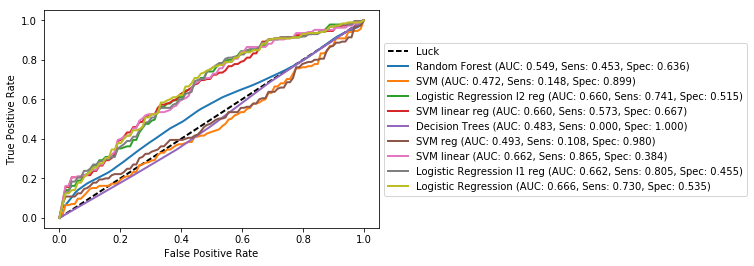

In [6]:
# Use PCA to remove feature vectors
xtrain_pca = xtrain.copy()
pca = PCA(n_components=6)
pca.fit(xtrain_pca)
xtrain_pca = pd.DataFrame(pca.transform(xtrain_pca),index=xtrain_pca.index)

# Try lower dimensional feature set on training data
make_aucs.main(data = [xtrain_pca, ytrain], models=models, kfolds=5)

### Try model with normalised data and PCA based feature reduction

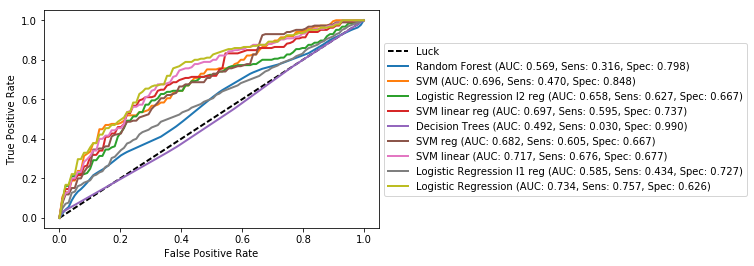

In [7]:
# Use PCA to remove feature vectors
xtrain_pca_norm = xtrain_norm.copy()
pca = PCA(n_components=6)
pca.fit(xtrain_pca_norm)
xtrain_pca_norm = pd.DataFrame(pca.transform(xtrain_pca_norm),index=xtrain_pca_norm.index)

# Try lower dimensional feature set on training data
make_aucs.main(data = [xtrain_pca_norm, ytrain], models=models, kfolds=5)

### Try model with polynomial features and normalisation

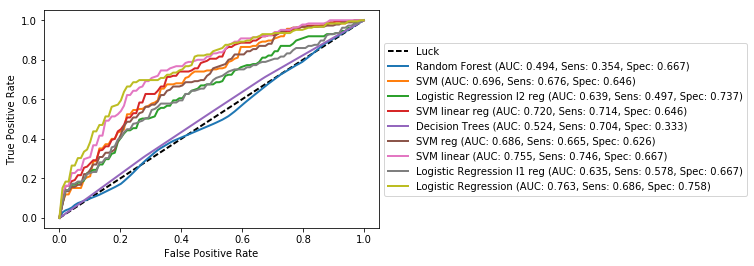

In [8]:
# Use polynomial features to encode higher degree interactions but only for continuous
xtrain_poly = xtrain_norm.copy()
xtrain_poly_temp = xtrain_norm.copy()
poly = preprocessing.PolynomialFeatures(degree=2)
poly.fit(xtrain_poly[continuous_variables])
cols_without_cont = list(set(xtrain_poly.columns) - set(continuous_variables))
xtrain_poly = pd.DataFrame(poly.transform(xtrain_poly[continuous_variables]),index=xtrain_poly.index)
xtrain_poly[cols_without_cont] = xtrain_poly_temp[cols_without_cont]

# Try lower dimensional feature set on training data
make_aucs.main(data = [xtrain_poly, ytrain], models=models, kfolds=5)

### Try model with polynomial features, normalisation and PCA feature reduction on continuous variables

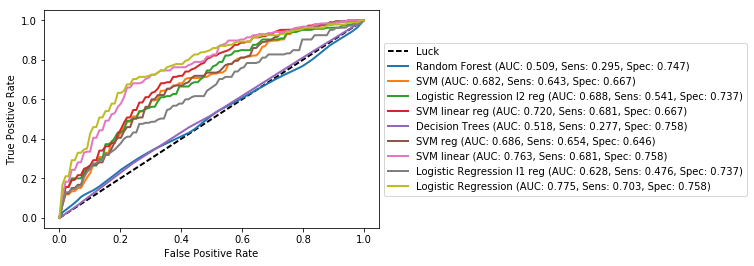

In [9]:
# Use polynomial features to encode higher degree interactions but only for continuous
xtrain_poly_pca_cont_norm = xtrain_norm.copy()
xtrain_poly_cont_temp = xtrain_norm.copy()
poly = preprocessing.PolynomialFeatures(degree=2)
poly.fit(xtrain_poly_pca_cont_norm[continuous_variables])
cols_without_cont = list(set(xtrain_poly_cont_temp.columns) - set(continuous_variables))
xtrain_poly_pca_cont_norm = pd.DataFrame(poly.transform(xtrain_poly_pca_cont_norm[continuous_variables]), \
                           index=xtrain_poly_pca_cont_norm.index)

pca = PCA(n_components=6)
pca.fit(xtrain_poly_pca_cont_norm)
xtrain_poly_pca_cont_norm = pd.DataFrame(pca.transform(xtrain_poly_pca_cont_norm),index=xtrain_poly_pca_cont_norm.index)

xtrain_poly_pca_cont_norm[cols_without_cont] = xtrain_poly_cont_temp[cols_without_cont]

# # Try lower dimensional feature set on training data
make_aucs.main(data = [xtrain_poly_pca_cont_norm, ytrain], models=models, kfolds=5)

### Try model with normalized continuous variables, and polynomial features and PCA feature reduction on all variables

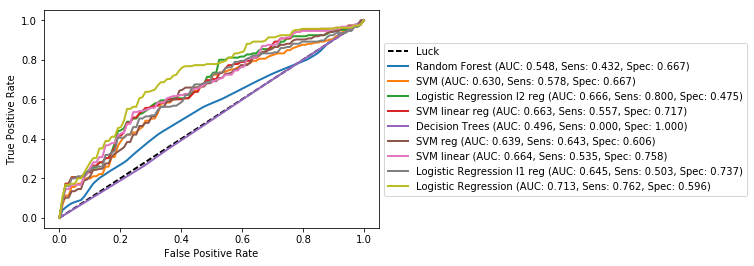

In [61]:
# Use polynomial features to encode higher degree interactions
xtrain_poly_pca_norm_all = xtrain_norm.copy()
poly = preprocessing.PolynomialFeatures(degree=2)
poly.fit(xtrain_poly_pca_norm_all)
xtrain_poly_pca_norm_all = pd.DataFrame(poly.transform(xtrain_poly_pca_norm_all), \
index=xtrain_poly_pca_norm_all.index)

pca = PCA(n_components=10)
pca.fit(xtrain_poly_pca_norm_all)
xtrain_poly_pca_norm_all = pd.DataFrame(pca.transform(xtrain_poly_pca_norm_all),index=xtrain_poly_pca_norm_all.index)

# xtrain_poly_pca_cont_norm[cols_without_cont] = xtrain_poly_cont_temp[cols_without_cont]

# # Try lower dimensional feature set on training data
make_aucs.main(data = [xtrain_poly_pca_norm_all, ytrain], models=models, kfolds=5)

### Try model with polynomial features on continuous normalized variables and PCA feature reduction on all variables

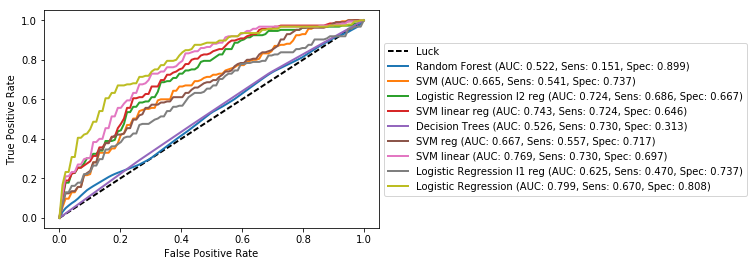

In [67]:
# Use PCA to remove feature vectors
xtrain_poly_pca_norm = xtrain_poly.copy()
pca = PCA(n_components=10)
pca.fit(xtrain_poly_pca_norm)
xtrain_poly_pca_norm = pd.DataFrame(pca.transform(xtrain_poly_pca_norm),index=xtrain_poly_pca_norm.index)

# Try lower dimensional feature set on training data
make_aucs.main(data = [xtrain_poly_pca_norm, ytrain], models=models, kfolds=5)

### Try Naive Bayes on columns chosen by Farah

AUROC score: 0.737 (+/- 0.101)


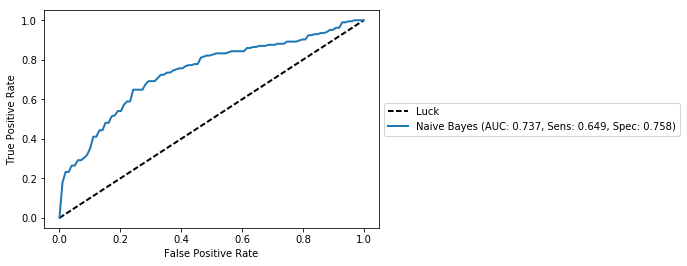

In [68]:
# Sort data into columns
NB_cols = ['bmi', 'tonsilsize_3-4', 'term', 'gender_Male']
xtrain_NB = xtrain.copy()
xtrain_NB = xtrain_NB[NB_cols]
model_NB = {'Naive Bayes': GaussianNB()}

# Test
make_aucs.main(data = [xtrain_NB, ytrain], models=model_NB, kfolds=5)

# Check against built-in cross_val_score
auroc_scores = cross_val_score(GaussianNB(), xtrain_NB, ytrain, cv=5, scoring ='roc_auc')
print("AUROC score: {:0.3f} (+/- {:0.3f})".format(auroc_scores.mean(), auroc_scores.std() * 2))

### Set up training and test data, train model on full training set

In [111]:
# Define best model
best_model = LogisticRegression()

# Create best data pipeline

# Creat copys of train and test set
xtrain_final = xtrain.copy()
xtest_final = xtest.copy()

# Normalise data
scaler = preprocessing.StandardScaler().fit(xtrain_final)
xtrain_final[continuous_variables] = pd.DataFrame(scaler.transform(xtrain_final), \
columns=xtrain_final.columns, index=xtrain_final.index)[continuous_variables]
xtest_final[continuous_variables] = pd.DataFrame(scaler.transform(xtest_final), \
columns=xtest_final.columns, index=xtest_final.index)[continuous_variables]

# Creat polynomial features on continuous variables
xtrain_poly_temp = xtrain_final.copy()
xtest_poly_temp = xtest_final.copy()
poly = preprocessing.PolynomialFeatures(degree=2)
poly.fit(xtrain_final[continuous_variables])
cols_without_cont = list(set(xtrain_final.columns) - set(continuous_variables))
xtrain_final = pd.DataFrame(poly.transform(xtrain_final[continuous_variables]),index=xtrain_final.index)
xtrain_final[cols_without_cont] = xtrain_poly_temp[cols_without_cont]
xtest_final = pd.DataFrame(poly.transform(xtest_final[continuous_variables]),index=xtest_final.index)
xtest_final[cols_without_cont] = xtest_poly_temp[cols_without_cont]

# Run PCA on all variables
pca = PCA(n_components=10)
pca.fit(xtrain_final)
xtrain_final = pd.DataFrame(pca.transform(xtrain_final),index=xtrain_final.index)
xtest_final = pd.DataFrame(pca.transform(xtest_final),index=xtest_final.index)

# Test cross-validation score on training set
auroc_scores = cross_val_score(best_model, xtrain_final, ytrain, cv=5, scoring ='roc_auc')
print('Training set cross-val AUC is: {:0.3f}'.format(auroc_scores.mean()))

Training set cross-val AUC is: 0.799


### Test reference surveys on test set

In [112]:
ref_sens_spec = {ref_metric: [] for ref_metric in reference_variables}

for ref_metric in reference_variables:
    ypred = pd.Series(yref[ref_metric]>=ref_thresh[ref_metric], index=yref.index)
    sensitivity, specificity = sens_and_spec(ytest, ypred)
    ref_sens_spec[ref_metric] = [sensitivity, specificity]

### Compare results on test set

In [113]:
# Train best model on training set
best_model.fit(xtrain_final, ytrain)

# Test best model on test set
pred_proba = best_model.predict_proba(xtest_final)[:, 1]
auc = metrics.roc_auc_score(ytest, pred_proba)
fpr, tpr, _ = metrics.roc_curve(ytest, pred_proba)
label = make_aucs.make_label('Best model using Youdens J Statistic', tpr, fpr, auc)
print(label, '\n')

# Compare sensitivity and specificity to reference values
for ref_metric in reference_variables:
    print('{} --> Sensitivity = {:0.3f}, Specificity = {:0.3f}'.format(ref_metric, \
    ref_sens_spec[ref_metric][0], ref_sens_spec[ref_metric][1]))
    sensitivity, specificity = match_sens(fpr, tpr, ref_sens_spec[ref_metric][0])
    print('Match sensitivity for {} --> Sensitivity = {:0.3f}, Specificity = {:0.3f}'.format(ref_metric, \
    sensitivity, specificity))
    sensitivity, specificity = match_spec(fpr, tpr, ref_sens_spec[ref_metric][1])
    print('Match specificity for {} --> Sensitivity = {:0.3f}, Specificity = {:0.3f}'.format(ref_metric, \
    sensitivity, specificity))
    print('')

Best model using Youdens J Statistic (AUC: 0.557, Sens: 0.393, Spec: 0.723) 

reference: osa18 --> Sensitivity = 0.360, Specificity = 0.701
Match sensitivity for reference: osa18 --> Sensitivity = 0.364, Specificity = 0.732
Match specificity for reference: osa18 --> Sensitivity = 0.402, Specificity = 0.701

reference: psq --> Sensitivity = 0.822, Specificity = 0.251
Match sensitivity for reference: psq --> Sensitivity = 0.822, Specificity = 0.234
Match specificity for reference: psq --> Sensitivity = 0.799, Specificity = 0.255

reference: ess --> Sensitivity = 0.364, Specificity = 0.636
Match sensitivity for reference: ess --> Sensitivity = 0.364, Specificity = 0.732
Match specificity for reference: ess --> Sensitivity = 0.425, Specificity = 0.667

